In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

from tqdm import tqdm
from IPython import display as ipythondisplay
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, states, actions, next_states, rewards, dones):
        for i in range(len(states)):
            transition = Transition(states[i], actions[i], next_states[i], rewards[i], dones[i])
            self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
    def act(self, state):
        with torch.no_grad():
            return self(state).max(-1).indices

In [4]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.01
LR = 5e-4

In [5]:
train_envs = gym.make_vec("CartPole-v1", num_envs=4, vectorization_mode="sync")
eval_envs = gym.make_vec("CartPole-v1", num_envs=1, vectorization_mode="sync")
vis_env = gym.make("CartPole-v1", render_mode="rgb_array")

n_observations = train_envs.observation_space.shape[0]
n_actions = train_envs.action_space.nvec[0]

In [6]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

In [7]:
def optimize_model() -> None:
    if len(memory) < BATCH_SIZE:
        return
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.stack(batch.state)
    next_states_batch = torch.stack(batch.next_state)

    action_batch = torch.stack(batch.action).to(torch.int64)
    reward_batch = torch.stack(batch.reward)
    
    done_batch = torch.stack(batch.done)

    state_action_values = policy_net(state_batch).gather(-1, action_batch.unsqueeze(-1))

    with torch.no_grad():
        next_state_values = target_net(next_states_batch).max(1).values
        next_state_values = torch.where(done_batch, torch.zeros_like(next_state_values, device=device), next_state_values)

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def eval() -> int:
    eval_state, _ = eval_envs.reset()
    for t in count():
        eval_state_tensor = torch.tensor(eval_state, dtype=torch.float32, device=device)

        action = target_net(eval_state_tensor).max(-1).indices

        observation, _, terminated, truncated, _ = eval_envs.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)

        eval_state = observation

        if(done.squeeze()):
            return t
        
def visualize() -> None:
    images = []
    vis_state, vis_info = vis_env.reset(seed=82)
    frame = vis_env.render()
    images.append(Image.fromarray(frame))
    for t in count():
        vis_state_tensor = torch.tensor(vis_state, dtype=torch.float32, device=device)

        action = target_net(vis_state_tensor).max(-1).indices

        observation, _, terminated, truncated, _ = vis_env.step(action.cpu().numpy())
        done = np.logical_or(terminated, truncated)
        vis_state = observation

        frame = vis_env.render()
        images.append(Image.fromarray(frame))

        if done.squeeze() or t >= 500:
            vis_env.close()
            break
    
    images[0].save(f'cartpole-v1-step-{t}.gif', save_all=True, append_images = images[1:], loop=0, duration=1)

Training Episodes: 100%|██████████| 1000/1000 [00:21<00:00, 46.16episode/s, weighted_avg_reward=187] 


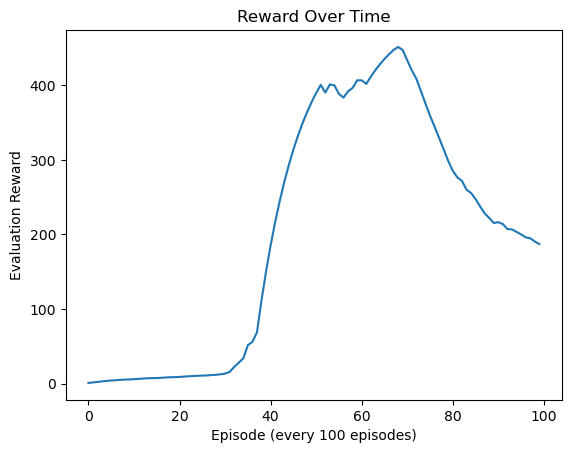

In [8]:
num_episodes = 1000
weighted_avg_reward = 0.0  # Initialize weighted average reward
reward_list = []

states, info = train_envs.reset()
states = torch.tensor(states, dtype=torch.float32, device=device)

with tqdm(range(num_episodes), desc="Training Episodes", unit="episode") as pbar:
    for i_episode in pbar:
        if random.random() > EPS_END + (EPS_START - EPS_END) *  math.exp(-1. * i_episode / EPS_DECAY):
            with torch.no_grad():
                actions =  policy_net(states).max(-1).indices.cpu().numpy()
        else:
            actions =  train_envs.action_space.sample()

        observations, reward, terminated, truncated, _ = train_envs.step(actions)
        dones = torch.tensor(np.logical_or(terminated, truncated), dtype=torch.bool, device=device)
        rewards = torch.tensor(reward, dtype=torch.float32, device=device)
        next_states = torch.tensor(observations, dtype=torch.float32, device=device)
        
        memory.push(states, torch.tensor(actions, dtype=torch.int32, device=device), next_states, rewards, dones)
        states = next_states

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            
        target_net.load_state_dict(target_net_state_dict)

        if i_episode % 10 == 0:
            t = eval()
            weighted_avg_reward = weighted_avg_reward * 0.9 + t * 0.1  # Update weighted average
            reward_list.append(weighted_avg_reward)
            pbar.set_postfix(weighted_avg_reward = weighted_avg_reward)

plt.plot(reward_list)
plt.xlabel('Episode (every 100 episodes)')
plt.ylabel('Evaluation Reward')
plt.title('Reward Over Time')
plt.show()

In [9]:
visualize()